# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS109A/STAT121A Introduction to Data Science 


## Lab 3:  KNN Regression, Simple Linear Regression

**Harvard University**<br>
**Fall 2018**<br>
**Instructors:** Pavlos Protopapas and Kevin Rader<br>
**Material Preparation:** David Sondak, Will Claybaugh, Eleni Kaxiras.

---

####  <font color='red'> Run the cell below to properly highlight the exercises</font>

In [40]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents
<ol start="1">
  <li> Array creation and reshape</li>
  <li> Some plotting
  <li> Simple linear regression  </li>
  <li> $k$-nearest neighbors</li>
</ol>

## Learning Goals

Overall description and goal for the lab.

By the end of this lab, you should be able to:
* Understand array reshaping
* Review how to make plots
* Feel comfortable with simple linear regression
* Feel comfortable with $k$ nearest neighbors

**This lab corresponds to lecture 4 and maps on to homework 2 (and beyond).**

In [41]:
# import the necessary libraries
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

## Simple Linear Regression
Linear regression and its many extensions are a workhorse of the statistics and data science community, both in application and as a reference point for other models. Most of the major concepts in machine learning can be and often are discussed in terms of various linear regression models. Thus, this section will introduce you to building and fitting linear regression models and some of the process behind it, so that you can 1) fit models to data you encounter 2) experiment with different kinds of linear regression and observe their effects 3) see some of the technology that makes regression models work.


### Linear regression with a toy dataset
We first examine a toy problem, focusing our efforts on fitting a linear model to a small dataset with three observations.  Each observation consists of one predictor $x_i$ and one response $y_i$ for $i = 1, 2, 3$,

\begin{align*}
(x , y) = \{(x_1, y_1), (x_2, y_2), (x_3, y_3)\}.
\end{align*}

To be very concrete, let's set the values of the predictors and responses.

\begin{equation*}
(x , y) = \{(1, 2), (2, 2), (3, 4)\}
\end{equation*}

There is no line of the form $\beta_0 + \beta_1 x = y$ that passes through all three observations, since the data are not collinear. Thus our aim is to find the line that best fits these observations in the *least-squares sense*, as discussed in lecture.

<div class="exercise"><b>Exercise (10 min)</b></div>

* Make two numpy arrays out of this data, x_train and y_train
* Check the dimentions of these arrays
* Try to reshape them into a different shape
* Make points into a very simple scatterplot
* Make a better scatterplot

In [42]:
# your code here
x_train = np.array([1,2,3])
y_train = np.array([2,3,6])
type(x_train)

numpy.ndarray

In [43]:
x_train.shape

(3,)

In [44]:
x_train = x_train.reshape(3,1)
x_train.shape

(3, 1)

In [45]:
xx = np.array([[1,3,5],[6,2,1]])
xx.shape

(2, 3)

In [46]:
xx = xx.reshape(3,-1)
xx

array([[1, 3],
       [5, 6],
       [2, 1]])

(3, 1) (3,)


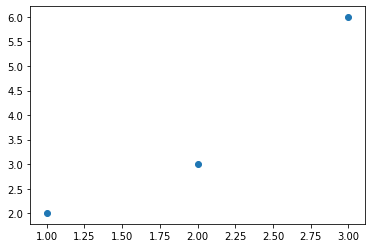

In [47]:
# %load solutions/simple_scatterplot.py
# Make a simple scatterplot
plt.scatter(x_train,y_train)

# check dimensions 
print(x_train.shape,y_train.shape)


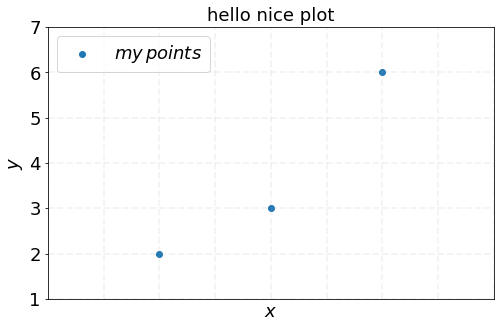

In [48]:
# %load solutions/nice_scatterplot.py
def nice_scatterplot(x, y, title):
    # font size
    f_size = 18
    
    # make the figure
    fig, ax = plt.subplots(1,1, figsize=(8,5)) # Create figure object

    # set axes limits to make the scale nice
    ax.set_xlim(np.min(x)-1, np.max(x) + 1)
    ax.set_ylim(np.min(y)-1, np.max(y) + 1)

    # adjust size of tickmarks in axes
    ax.tick_params(labelsize = f_size)
    
    # remove tick labels
    ax.tick_params(labelbottom=False,  bottom=False)
    
    # adjust size of axis label
    ax.set_xlabel(r'$x$', fontsize = f_size)
    ax.set_ylabel(r'$y$', fontsize = f_size)
    
    # set figure title label
    ax.set_title(title, fontsize = f_size)

    # you may set up grid with this 
    ax.grid(True, lw=1.75, ls='--', alpha=0.15)

    # make actual plot (Notice the label argument!)
    #ax.scatter(x, y, label=r'$my points$')
    #ax.scatter(x, y, label='$my points$')
    ax.scatter(x, y, label=r'$my\,points$')
    ax.legend(loc='best', fontsize = f_size);
    
    return ax

nice_scatterplot(x_train, y_train, 'hello nice plot')



#### Formulae
Linear regression is special among the models we study beuase it can be solved explicitly. While most other models (and even some advanced versions of linear regression) must be solved itteratively, linear regression has a formula where you can simply plug in the data.

For the single predictor case it is:
    \begin{align}
      \beta_1 &= \frac{\sum_{i=1}^n{(x_i-\bar{x})(y_i-\bar{y})}}{\sum_{i=1}^n{(x_i-\bar{x})^2}}\\
      \beta_0 &= \bar{y} - \beta_1\bar{x}\
    \end{align}
    
Where $\bar{y}$ and $\bar{x}$ are the mean of the y values and the mean of the x values, respectively.

From the re-aranged second equation we can see that the best-fit line  passes through $(\bar{x},\bar{y})$, the center of mass of the data

From any of the first equations, we can see that the slope of the line has to do with whether or not an x value that is above/below the center of mass is typically paired with a y value that is likewise above/below, or typically paired with one that is opposite.

###  Building a model from scratch
In this part, we will solve the equations for simple linear regression and find the best fit solution to our toy problem.

The snippets of code below implement the linear regression equations on the observed predictors and responses, which we'll call the training data set.  Let's walk through the code.

We have to reshape our arrrays to 2D. We will see later why.

<div class="exercise"><b>Exercise (5 min)</b></div>
* make an array with shape (2,3)
* reshape it to a size that you want

In [49]:
# your code here
xx = np.array([[1,2,3],[4,6,8]])
xxx = xx.reshape(-1,2)
xxx.shape

(3, 2)

In [50]:
# Reshape to be a proper 2D array
x_train = x_train.reshape(x_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

print(x_train.shape)

(3, 1)


In [51]:
# first, compute means
y_bar = np.mean(y_train)
x_bar = np.mean(x_train)

# build the two terms
numerator = np.sum( (x_train - x_bar)*(y_train - y_bar) )
denominator = np.sum((x_train - x_bar)**2)

print(numerator.shape, denominator.shape) #check shapes

() ()


* Why the empty brackets? (The numerator and denominator are scalars, as expected.)

In [52]:
#slope beta1
beta_1 = numerator/denominator

#intercept beta0
beta_0 = y_bar - beta_1*x_bar

print("The best-fit line is {0:3.2f} + {1:3.2f} * x".format(beta_0, beta_1))
print(f'The best fit is {beta_0}')

The best-fit line is -0.33 + 2.00 * x
The best fit is -0.3333333333333335


<div class="exercise"><b>Exercise (5 min)</b></div>

Turn the code from the above cells into a function called `simple_linear_regression_fit`, that inputs the training data and returns `beta0` and `beta1`.

To do this, copy and paste the code from the above cells below and adjust the code as needed, so that the training data becomes the input and the betas become the output.

```python
def simple_linear_regression_fit(x_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
    
    return
```

Check your function by calling it with the training data from above and printing out the beta values.

In [53]:
# Your code here

In [54]:
# %load solutions/simple_linear_regression_fit.py
def simple_linear_regression_fit(x_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
    """
    Inputs:
    x_train: a (num observations by 1) array holding the values of the predictor variable
    y_train: a (num observations by 1) array holding the values of the response variable

    Returns:
    beta_vals:  a (num_features by 1) array holding the intercept and slope coeficients
    """
    
    # Check input array sizes
    if len(x_train.shape) < 2:
        print("Reshaping features array.")
        x_train = x_train.reshape(x_train.shape[0], 1)

    if len(y_train.shape) < 2:
        print("Reshaping observations array.")
        y_train = y_train.reshape(y_train.shape[0], 1)

    # first, compute means
    y_bar = np.mean(y_train)
    x_bar = np.mean(x_train)

    # build the two terms
    numerator = np.sum( (x_train - x_bar)*(y_train - y_bar) )
    denominator = np.sum((x_train - x_bar)**2)
    
    #slope beta1
    beta_1 = numerator/denominator

    #intercept beta0
    beta_0 = y_bar - beta_1*x_bar

    return np.array([beta_0,beta_1])


* Let's run this function and see the coefficients

In [55]:
x_train = np.array([1 ,2, 3])
y_train = np.array([2, 2, 4])

betas = simple_linear_regression_fit(x_train, y_train)

beta_0 = betas[0]
beta_1 = betas[1]

print("The best-fit line is {0:8.6f} + {1:8.6f} * x".format(beta_0, beta_1))

Reshaping features array.
Reshaping observations array.
The best-fit line is 0.666667 + 1.000000 * x


<div class="exercise"><b>Exercise (5 min)</b></div>
* Do the values of `beta0` and `beta1` seem reasonable?
* Plot the training data using a scatter plot.
* Plot the best fit line with `beta0` and `beta1` together with the training data.

In [56]:
# Your code here

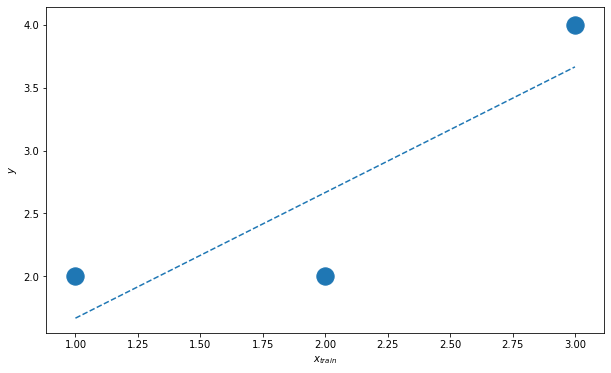

In [57]:
# %load solutions/best_fit_scatterplot.py
fig_scat, ax_scat = plt.subplots(1,1, figsize=(10,6))

# Plot best-fit line
x_train = np.array([[1, 2, 3]]).T

best_fit = beta_0 + beta_1 * x_train

ax_scat.scatter(x_train, y_train, s=300, label='Training Data')
ax_scat.plot(x_train, best_fit, ls='--', label='Best Fit Line')

ax_scat.set_xlabel(r'$x_{train}$')
ax_scat.set_ylabel(r'$y$');


The values of `beta0` and `beta1` seem roughly reasonable.  They capture the positive correlation.  The line does appear to be trying to get as close as possible to all the points.

### Building a model with `statsmodels` and `sklearn`

Now that we can concretely fit the training data from scratch, let's learn two `python` packages to do it all for us:
* [statsmodels](http://www.statsmodels.org/stable/regression.html) and 
* [scikit-learn (sklearn)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Our goal  is to show how to implement simple linear regression with these packages.  For an important sanity check, we compare the $\beta$ values from `statsmodels` and `sklearn` to the $\beta$ values that we found from above with our own implementation.

For the purposes of this lab, `statsmodels` and `sklearn` do the same thing.  More generally though, `statsmodels` tends to be easier for inference \[finding the values of the slope and intercept and dicussing uncertainty in those values\], whereas `sklearn` has machine-learning algorithms and is better for prediction \[guessing y values for a given x value\]. (Note that both packages make the same guesses, it's just a question of which activity they provide more support for.

**Note:** `statsmodels` and `sklearn` are different packages!  Unless we specify otherwise, you can use either one.

Below is the code for `statsmodels`.  `Statsmodels` does not by default include the column of ones in the $X$ matrix, so we include it manually with `sm.add_constant`.

In [58]:
import statsmodels.api as sm

In [59]:
# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(x_train)

# this is the same matrix as in our scratch problem!
print(X)

# build the OLS model (ordinary least squares) from the training data
toyregr_sm = sm.OLS(y_train, X)

# do the fit and save regression info (parameters, etc) in results_sm
results_sm = toyregr_sm.fit()

# pull the beta parameters out from results_sm
beta0_sm = results_sm.params[0]
beta1_sm = results_sm.params[1]

print("The regression coefficients from the statsmodels package are: beta_0 = {0:8.6f} and beta_1 = {1:8.6f}".format(beta0_sm, beta1_sm))

[[1. 1.]
 [1. 2.]
 [1. 3.]]
The regression coefficients from the statsmodels package are: beta_0 = 0.666667 and beta_1 = 1.000000


Besides the beta parameters, `results_sm` contains a ton of other potentially useful information.

In [60]:
import warnings
warnings.filterwarnings('ignore')
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     3.000
Date:                Wed, 29 Jan 2020   Prob (F-statistic):              0.333
Time:                        14:29:20   Log-Likelihood:                -2.0007
No. Observations:                   3   AIC:                             8.001
Df Residuals:                       1   BIC:                             6.199
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667      1.247      0.535      0.6

Now let's turn our attention to the `sklearn` library.

In [61]:
from sklearn import linear_model

In [62]:
# build the least squares model
toyregr = linear_model.LinearRegression()

# save regression info (parameters, etc) in results_skl
results = toyregr.fit(x_train, y_train)

# pull the beta parameters out from results_skl
beta0_skl = toyregr.intercept_
beta1_skl = toyregr.coef_[0]

print("The regression coefficients from the sklearn package are: beta_0 = {0:8.6f} and beta_1 = {1:8.6f}".format(beta0_skl, beta1_skl))

The regression coefficients from the sklearn package are: beta_0 = 0.666667 and beta_1 = 1.000000


We should feel pretty good about ourselves now, and we're ready to move on to a real problem!

### The shape of things in `scikit-learn`
Before diving right in to a "real" problem, we really ought to discuss more of the details of `sklearn`.  We do this now.  Along the way, we'll import the real-world dataset.

`Scikit-learn` is the main `python` machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`. It can be used in `python` by the incantation `import sklearn`.

In scikit-learn, an **estimator** is a Python object that implements the methods fit(X, y) and predict(T)

Let's see the structure of `scikit-learn` needed to make these fits. `.fit` always takes two arguments:
```python
  estimator.fit(Xtrain, ytrain)
```
We will consider two estimators in this lab: `LinearRegression` and `KNeighborsRegressor`.

Critically, `Xtrain` must be in the form of an *array of arrays* (or a 2x2 array) with the inner arrays each corresponding to one sample, and whose elements correspond to the feature values for that sample (visuals coming in a moment).

`ytrain` on the other hand is a simple array of responses.  These are continuous for regression problems.

![](images/sklearn2.jpg)

### Practice with `sklearn`
We begin by loading up the `mtcars` dataset and cleaning it up a little bit.

In [63]:
import pandas as pd

#load mtcars
dfcars = pd.read_csv("../data/mtcars.csv")
dfcars = dfcars.rename(columns={"Unnamed: 0":"car name"})
dfcars.head()

,car name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Next, let's split the dataset into a training set and test set.

In [64]:
# split into training set and testing set
from sklearn.model_selection import train_test_split

#set random_state to get the same split every time
traindf, testdf = train_test_split(dfcars, test_size=0.2, random_state=42)

In [65]:
# testing set is around 20% of the total data; training set is around 80%
print("Shape of full dataset is: {0}".format(dfcars.shape))
print("Shape of training dataset is: {0}".format(traindf.shape))
print("Shape of test dataset is: {0}".format(testdf.shape))

Shape of full dataset is: (32, 12)
Shape of training dataset is: (25, 12)
Shape of test dataset is: (7, 12)


Now we have training and test data.  We still need to select a predictor and a response from this dataset.  Keep in mind that we need to choose the predictor and response from both the training and test set.  You will do this in the exercises below.  However, we provide some starter code for you to get things going.

In [66]:
# Extract the response variable that we're interested in
y_train = traindf.mpg

Notice the shape of `y_train`.

In [67]:
np.shape(y_train)

(25,)

Another way to see the shape is to use the shape method.

In [68]:
y_train.shape

(25,)

This is *not* an "array of arrays".  That's okay!  Remember, `sklearn` requires an array of arrays only for the predictor array!  You will have to pay close attention to this in the exercises later.

For now, let's discuss two ways out of this debacle.  All we'll do is get `y_train` to be an array of arrays.  This doesn't hurt anything because `sklearn` doesn't care too much about the shape of `y_train`.

First, let's reshape `y_train` to be an array of arrays using the `reshape` method.  We want the first dimension of `y_train` to be size $25$ and the second dimension to be size $1$.

In [69]:
y_train_reshape = y_train.values.reshape(y_train.shape[0], 1)

In [70]:
y_train_reshape.shape

(25, 1)

Notice that `y_train.shape[0]` gives the size of the first dimension.

There's an even easier way to get the correct shape right from the beginning.

In [71]:
y_train_reshape = traindf[['mpg']]

In [72]:
y_train_reshape.shape

(25, 1)

Finally, there is a nice shortcut to reshaping an array.  `numpy` can infer a dimension based on the other dimensions specified.

In [73]:
y_train_reshape = y_train.values.reshape(-1,1)
y_train_reshape.shape

(25, 1)

In this case, we said the second dimension should be size $1$.  Since the requirement of the `reshape()` method is that the requested dimensions be compatible, `numpy` decides the the first dimension must be size $25$.

What would the `.shape` return if we did `y_train.values.reshape(-1,5)`?

Okay, enough of that.  The whole reason we went through that whole process was to show you how to reshape your data into the correct format.

**IMPORTANT:** Remember that your response variable `ytrain` can be a vector but your predictor variable `xtrain` ***must*** be an array!

### Simple linear regression with automobile data
We will now use `sklearn` to predict automobile mileage per gallon (mpg) and evaluate these predictions. We already loaded the data and split them into a training set and a test set.

We need to choose the variables that we think will be good predictors for the dependent variable `mpg`. 

<div class="exercise"><b>Exercise (10 min)</b></div>
* Pick one variable to use as a predictor for simple linear regression.  Create a markdown cell below and discuss your reasons.  
* Justify your choice with some visualizations.  
* Is there a second variable you'd like to use? For example, we're not doing multiple linear regression here, but if we were, is there another variable you'd like to include if we were using two predictors?

In [74]:
# Your code here

Text(0, 0.5, 'Car MPG')

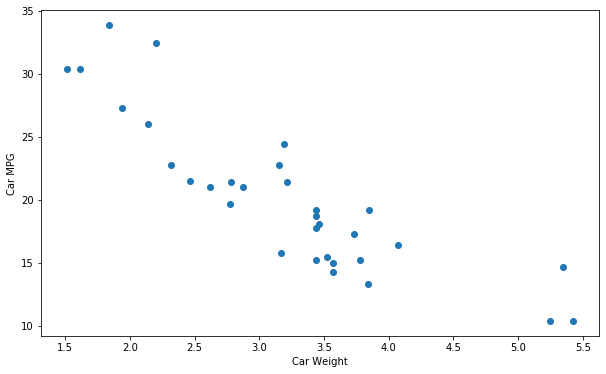

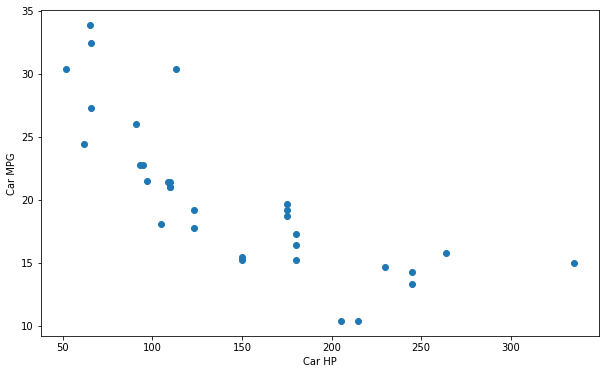

In [75]:
# %load solutions/cars_simple_EDA.py
y_mpg = dfcars.mpg
x_wt = dfcars.wt
x_hp = dfcars.hp

fig_wt, ax_wt = plt.subplots(1,1, figsize=(10,6))
ax_wt.scatter(x_wt, y_mpg)
ax_wt.set_xlabel(r'Car Weight')
ax_wt.set_ylabel(r'Car MPG')

fig_hp, ax_hp = plt.subplots(1,1, figsize=(10,6))
ax_hp.scatter(x_hp, y_mpg)
ax_hp.set_xlabel(r'Car HP')
ax_hp.set_ylabel(r'Car MPG')


<div class="exercise"><b>Exercise</b></div>

* Use `sklearn` to fit the training data using simple linear regression.
* Use the model to make mpg predictions on the test set.  
* Plot the data and the prediction.  
* Print out the mean squared error for the training set and the test set and compare.

**Hints:**
* Use the following to perform the analysis:
```python
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
```

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dfcars = pd.read_csv("../data/mtcars.csv")
dfcars = dfcars.rename(columns={"Unnamed: 0":"name"})

dfcars.head()

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [89]:
traindf, testdf = train_test_split(dfcars, test_size=0.2, random_state=42)

y_train = np.array(traindf.mpg)
X_train = np.array(traindf[['wt']])
X_train = X_train.reshape(X_train.shape[0], 1)

In [90]:
y_test = np.array(testdf.mpg)
X_test = np.array(testdf.wt)
X_test = X_test.reshape(X_test.shape[0], 1)

#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train, y_train)

predicted_y = regression.predict(X_test)

r2 = regression.score(X_test, y_test)
print(r2)

0.6879761857596272


In [91]:
print(regression.score(X_train, y_train))

print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(X_train)))

print('Coefficients: \n', regression.coef_[0], regression.intercept_)

0.7701379909791617
12.475985659918837
7.773697766387512
Coefficients: 
 -5.336941400557081 36.93731031351841


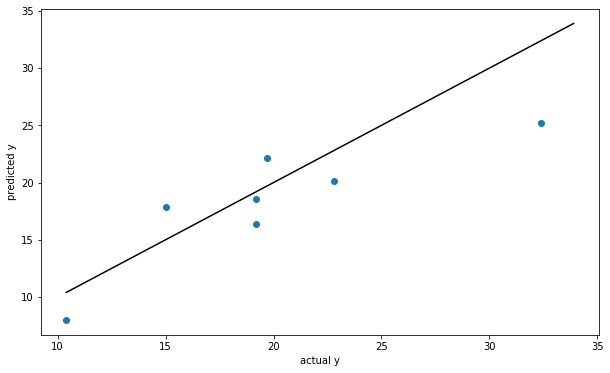

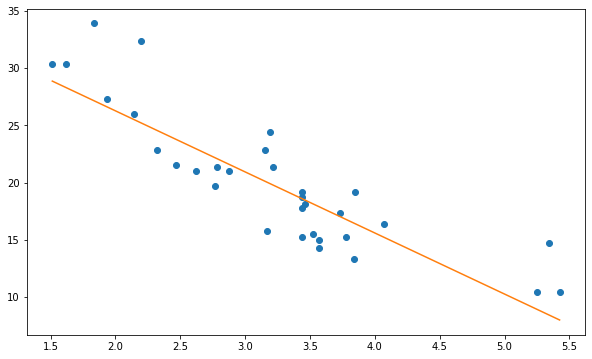

In [92]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(dfcars.mpg), np.max(dfcars.mpg), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("actual y")
ax.set_ylabel("predicted y")

fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(dfcars.wt, dfcars.mpg, 'o')
xgrid = np.linspace(np.min(dfcars.wt), np.max(dfcars.wt), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))

## $k$-nearest neighbors

Great, so we did a simple linear regression on the car data.

Now that you're familiar with `sklearn`, you're ready to do a KNN regression.  Let's use $5$ nearest neighbors.

In [93]:
from sklearn.neighbors import KNeighborsRegressor
knnreg = KNeighborsRegressor(n_neighbors=5)

In [94]:
knnreg.fit(X_train, y_train)
r2 = knnreg.score(X_test, y_test)
r2

0.6992188728167332

<div class="exercise"><b>Exercise</b></div>
What is the $R^{2}$ score on the training set?

In [ ]:
# Your code here

In [95]:
# solution
knnreg.score(X_train, y_train)

0.8718092469742431

Lets vary the number of neighbors and see what we get.

In [96]:
regdict = {}
# Do a bunch of KNN regressions
for k in [1, 2, 4, 6, 8, 10, 15]:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(X_train, y_train)
    regdict[k] = knnreg # Store the regressors in a dictionary

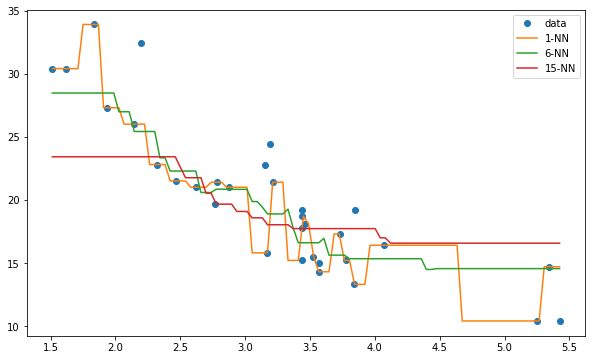

In [97]:
# Now let's plot it all
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(dfcars.wt, dfcars.mpg, 'o', label="data")

xgrid = np.linspace(np.min(dfcars.wt), np.max(dfcars.wt), 100)
for k in [1, 2, 6, 10, 15]:
    predictions = regdict[k].predict(xgrid.reshape(100,1))
    if k in [1, 6, 15]:
        ax.plot(xgrid, predictions, label="{}-NN".format(k))

ax.legend();

Notice how the $1$-NN goes through every point on the training set but utterly fails elsewhere. Lets look at the scores on the training set.

Text(0, 0.5, '$R^{2}$')

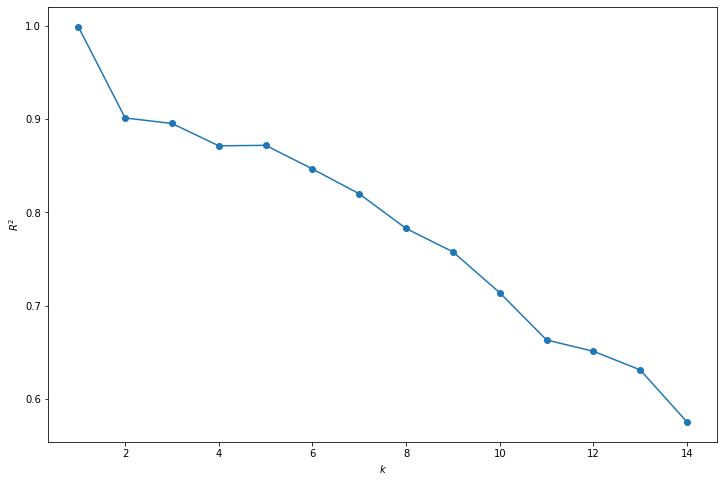

In [98]:
ks = range(1, 15) # Grid of k's
scores_train = [] # R2 scores
for k in ks:
    knnreg = KNeighborsRegressor(n_neighbors=k) # Create KNN model
    knnreg.fit(X_train, y_train) # Fit the model to training data
    score_train = knnreg.score(X_train, y_train) # Calculate R^2 score
    scores_train.append(score_train)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(ks, scores_train,'o-')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')

Why do we get a perfect $R^2$ at k=1?

<div class="exercise"><b>Exercise (5 min)</b></div>
* Make the same plot as above on the *test* set.
* What is the best $k$?

In [ ]:
# Your code here

In [ ]:
# %load solutions/knn_regression.py